# Extended inference

This demo shows the following inference options:

- big data inference
- iterable data load and inference
- labels passing

We will generage wyth `pyspark` a big dataset with transactions and other fields.

Since the dataset is large, we will use an iterable dataset to save memory and enable data loading and GPU output in parallel.

We don't need only embeddings. We need them with user_id, target, labels and other fields. We should keep it together for large iterable dataset.

# Data generation

In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import Window
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [3]:
spark_conf = SparkConf()
spark_conf.setMaster("local[8]").setAppName("pyspark_data_generation")
spark_conf.set("spark.executor.memory", "32g")
spark_conf.set("spark.executor.memoryOverhead", "4g")
spark_conf.set("spark.driver.memory", "32g")
spark_conf.set("spark.driver.memoryOverhead", "4g")
spark_conf.set("spark.local.dir", "./spark_local_dir")

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

22/07/22 14:23:23 WARN Utils: Your hostname, vm2 resolves to a loopback address: 127.0.1.1; using 192.168.0.6 instead (on interface ens192)
22/07/22 14:23:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/22 14:23:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/07/22 14:23:24 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/07/22 14:23:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/07/22 14:23:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/07/22 14:23:25 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [4]:
spark

In [5]:
import random
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
from urllib.request import urlretrieve
data, _ = urlretrieve(
    'https://huggingface.co/datasets/dllllb/age-group-prediction/resolve/main/transactions_train.csv.gz?download=true',
    'transactions_train.csv.gz')

df_real_trx = spark.read.csv(data, header=True) \
.select(
    F.col('trans_date').cast('float'), 
    'small_group',
    F.col('amount_rur').cast('float'),
)
df_real_trx.limit(5).toPandas()

,trans_date,small_group,amount_rur
0,6.0,4,71.462997
1,6.0,35,45.016998
2,8.0,11,13.887000
3,9.0,11,15.983000
4,10.0,11,21.341000


In [8]:
real_trx_count = df_real_trx.count()
real_trx_count

26450577

In [9]:
USER_CNT = 1e6
TOTAL_TRX_FOR_GENERATE = 800 * USER_CNT

In [10]:
df_generated = df_real_trx.sample(fraction=TOTAL_TRX_FOR_GENERATE / real_trx_count, withReplacement=True)
df_generated = df_generated.repartition(200)

In [11]:
df_generated = df_generated.withColumn('user_id', F.concat(F.lit('u_'), F.floor(F.rand() * USER_CNT)))

In [12]:
df_generated = df_generated.withColumn('event_time', F.rand())

In [13]:
df_generated.limit(5).toPandas()

,trans_date,small_group,amount_rur,user_id,event_time
0,649.0,18,10.991000,u_599206,0.246618
1,593.0,15,5.908000,u_195427,0.439432
2,354.0,1,3.704000,u_527251,0.167604
3,419.0,34,63.700001,u_44570,0.924908
4,216.0,4,10.221000,u_403353,0.706942


In [14]:
%%time
df_generated.write.parquet('df_generated.parquet', mode='overwrite')
df_generated = spark.read.parquet('df_generated.parquet')

CPU times: user 195 ms, sys: 8.79 ms, total: 203 ms
Wall time: 4min 2s


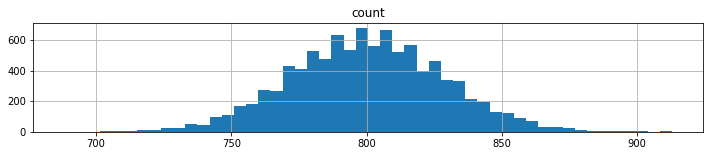

CPU times: user 606 ms, sys: 785 ms, total: 1.39 s
Wall time: 1min 20s


In [15]:
%%time
df_generated.groupby('user_id').count().select('count') \
.sample(True, fraction=1e4 / USER_CNT).toPandas().hist(bins=50, figsize=(12, 2))
plt.show()

In [16]:
from ptls.preprocessing import PysparkDataPreprocessor

preprocessor = PysparkDataPreprocessor(
    col_id='user_id',
    col_event_time='event_time',
    event_time_transformation='none',
    cols_category=['small_group'],
    cols_numerical=['amount_rur'],
)

In [17]:
%%time
df_gen_features = preprocessor.fit_transform(df_generated)

22/07/22 14:31:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/22 14:31:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/22 14:31:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/07/22 14:31:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/22 14:31:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/22 14:31:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/22 14:31:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


CPU times: user 70.1 ms, sys: 65.8 ms, total: 136 ms
Wall time: 9.78 s


In [18]:
df_gen_features = df_gen_features.withColumn('target', F.round(F.rand()).cast('int'))

In [19]:
%%time
df_gen_features.write.parquet('df_gen_features.parquet', mode='overwrite')

CPU times: user 350 ms, sys: 32.1 ms, total: 382 ms
Wall time: 8min 26s


In [20]:
!du -sh df_gen_features.parquet

9.5G	df_gen_features.parquet


In [21]:
spark.stop()

In [22]:
preprocessor.get_category_dictionary_sizes()

{'small_group': 204}

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
import pytorch_lightning as pl

from tqdm.auto import tqdm

## Data for inferenfce

In [3]:
from ptls.data_load.datasets import ParquetDataset, ParquetFiles
from ptls.data_load.iterable_processing import ISeqLenLimit
from ptls.data_load.utils import collate_feature_dict

In [4]:
iterable_inference_dataset = ParquetDataset(
    data_files=ParquetFiles('df_gen_features.parquet').data_files,
    i_filters=[
        ISeqLenLimit(max_seq_len=2000), 
    ],
)
next(iter(iterable_inference_dataset))

{'user_id': 'u_100002',
 'trans_date': tensor([425., 297., 227., 199., 165., 236., 387., 608.,  18., 160., 569., 586.,
         641., 650., 605., 579., 551., 568., 702., 383.,  34., 422., 221., 342.,
         719., 255.,  57., 492.,  58.,  61., 509., 181., 396., 601., 253., 303.,
         663., 532., 521., 519.,  55., 400., 399., 322., 539., 638., 531., 317.,
         133.,   5.,  32., 456., 239., 572., 266.,  33., 627., 306., 653., 100.,
         650., 383.,  10., 175., 484., 694., 610., 226., 125., 577., 134., 115.,
         577., 631., 102., 245.,  15., 568., 607., 164., 601., 476., 208., 657.,
         524.,  47., 418., 379., 713.,  34.,  68., 177., 619., 466., 158., 425.,
         250., 583., 341., 319., 382., 141., 652., 147.,  11., 607., 531., 507.,
         692., 603.,   0., 374., 496., 138., 724., 414., 728.,  16., 360., 214.,
         130.,  41., 348., 339., 567.,  56., 618., 113., 250., 189., 553., 445.,
         707., 669., 512.,  16., 138., 687., 543., 364., 438., 668., 19

In [5]:
%%time
for rec in tqdm(iterable_inference_dataset):
    pass

0it [00:00, ?it/s]

CPU times: user 1min 1s, sys: 12 s, total: 1min 13s
Wall time: 1min 10s


In [6]:
inference_dl = torch.utils.data.DataLoader(
    dataset=iterable_inference_dataset,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=1000,
    num_workers=12,
)
next(iter(inference_dl)).payload

{'user_id': array(['u_100002', 'u_100093', 'u_100292', 'u_100302', 'u_100467',
        'u_100543', 'u_1006', 'u_100643', 'u_100697', 'u_100875',
        'u_100906', 'u_10141', 'u_102102', 'u_102346', 'u_102662',
        'u_102862', 'u_102942', 'u_102967', 'u_103141', 'u_103333',
        'u_103364', 'u_103406', 'u_103412', 'u_103587', 'u_103616',
        'u_103761', 'u_104104', 'u_104166', 'u_104405', 'u_104454',
        'u_104702', 'u_104965', 'u_105212', 'u_10554', 'u_105673',
        'u_106243', 'u_106396', 'u_106406', 'u_106428', 'u_106478',
        'u_106919', 'u_1070', 'u_107084', 'u_107220', 'u_107749',
        'u_10788', 'u_107905', 'u_108305', 'u_108622', 'u_108786',
        'u_108924', 'u_108929', 'u_109173', 'u_10929', 'u_109433',
        'u_109435', 'u_109465', 'u_110009', 'u_110042', 'u_110060',
        'u_110168', 'u_110258', 'u_110574', 'u_110697', 'u_110745',
        'u_110892', 'u_110909', 'u_111003', 'u_111037', 'u_111066',
        'u_111100', 'u_111664', 'u_112134', '

In [7]:
%%time
for rec in tqdm(inference_dl):
    pass

0it [00:00, ?it/s]

CPU times: user 1.73 s, sys: 2.52 s, total: 4.25 s
Wall time: 13.3 s


## Model

In [8]:
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.inference_module import InferenceModule

In [9]:
# random model in demo
# use trained model for real usage
seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(
        embeddings={
            'trans_date': {'in': 800, 'out': 32}, 
            'small_group': {'in': 200, 'out': 32},
        },
        numeric_values={'amount_rur': 'log'},
    ),
    hidden_size=256,
)

In [10]:
model = InferenceModule(model=seq_encoder, pandas_output=True, model_out_name='emb')

## Iterable inference

In [11]:
predict = pl.Trainer(gpus=1).predict(model, inference_dl)

/home/kireev/pipenv_envs/pytorch-lifestream-KxQJF1XF/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

/home/kireev/pipenv_envs/pytorch-lifestream-KxQJF1XF/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [12]:
predict[0]

,user_id,target,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,...,emb_0246,emb_0247,emb_0248,emb_0249,emb_0250,emb_0251,emb_0252,emb_0253,emb_0254,emb_0255
0,u_100002,0,0.028287,-0.165995,0.126620,-0.032016,0.016137,0.039828,0.159993,-0.224086,...,0.077100,0.044393,0.242713,-0.043127,0.023614,-0.002254,-0.142776,-0.221038,0.057583,-0.007864
1,u_100093,0,0.236783,0.364345,-0.108432,0.070790,0.099409,-0.119790,0.510778,-0.231560,...,-0.031448,0.040263,0.045545,-0.006918,0.129049,0.071746,-0.210788,0.288435,-0.107366,-0.176545
2,u_100292,1,0.060974,0.015578,0.074314,-0.015297,-0.072065,-0.228197,0.084782,-0.316223,...,0.065913,-0.209312,0.186426,-0.014417,0.184326,-0.065463,-0.388418,0.221885,0.136650,-0.183059
3,u_100302,1,0.166716,-0.381586,-0.064041,-0.077300,0.254902,0.121023,0.516134,0.047728,...,-0.099801,-0.444753,-0.323648,0.066342,0.204678,-0.088744,-0.335036,0.024014,0.137864,-0.232802
4,u_100467,0,0.102175,0.026828,-0.128542,-0.134966,0.112983,0.093400,0.189535,0.082395,...,-0.100227,-0.016402,-0.132673,0.066391,-0.018519,-0.252219,-0.096244,-0.078941,0.241028,0.102450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,u_27656,1,0.013051,0.091127,0.090885,-0.243966,0.262145,0.183707,0.482889,-0.085619,...,0.017391,-0.012522,-0.188911,0.075924,0.288637,0.184379,0.000888,0.193466,0.131888,-0.288630
996,u_276935,1,0.167983,0.154561,-0.059162,-0.200115,-0.012947,-0.068747,0.398722,-0.073746,...,0.054446,-0.009374,0.225024,-0.086913,0.225870,0.094627,0.005300,0.057958,0.311267,-0.215860
997,u_277096,1,0.102818,-0.004892,0.256763,-0.242788,0.213398,0.252951,0.247898,-0.035680,...,0.056761,-0.405258,-0.005567,0.203767,0.260439,0.091790,0.115536,0.036998,0.060348,-0.020778
998,u_277131,0,0.234514,0.465364,0.182645,-0.267335,0.109032,0.169204,0.133215,-0.113944,...,0.107012,0.138886,0.146164,0.094512,0.062334,-0.091048,-0.295387,0.091000,0.437284,-0.400930


In [13]:
full_predict = pd.concat(predict, axis=0)
full_predict.head()

,user_id,target,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,...,emb_0246,emb_0247,emb_0248,emb_0249,emb_0250,emb_0251,emb_0252,emb_0253,emb_0254,emb_0255
0,u_100002,0,0.028287,-0.165995,0.126620,-0.032016,0.016137,0.039828,0.159993,-0.224086,...,0.077100,0.044393,0.242713,-0.043127,0.023614,-0.002254,-0.142776,-0.221038,0.057583,-0.007864
1,u_100093,0,0.236783,0.364345,-0.108432,0.070790,0.099409,-0.119790,0.510778,-0.231560,...,-0.031448,0.040263,0.045545,-0.006918,0.129049,0.071746,-0.210788,0.288435,-0.107366,-0.176545
2,u_100292,1,0.060974,0.015578,0.074314,-0.015297,-0.072065,-0.228197,0.084782,-0.316223,...,0.065913,-0.209312,0.186426,-0.014417,0.184326,-0.065463,-0.388418,0.221885,0.136650,-0.183059
3,u_100302,1,0.166716,-0.381586,-0.064041,-0.077300,0.254902,0.121023,0.516134,0.047728,...,-0.099801,-0.444753,-0.323648,0.066342,0.204678,-0.088744,-0.335036,0.024014,0.137864,-0.232802
4,u_100467,0,0.102175,0.026828,-0.128542,-0.134966,0.112983,0.093400,0.189535,0.082395,...,-0.100227,-0.016402,-0.132673,0.066391,-0.018519,-0.252219,-0.096244,-0.078941,0.241028,0.102450


In [14]:
full_predict.shape

(1000000, 258)

In [15]:
full_predict.to_parquet('full_predict.parquet')

In [16]:
!du -sh full_predict.parquet

1.2G	full_predict.parquet
